In [72]:
# =========================
# 🔹 SECTION 1: SETUP & LOAD DATA
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Load datasets
turnout_df = pd.read_csv("data/Extended_Master_VoterTurnout_Dataset.csv")
vote_share_df = pd.read_csv("data/ClintonTwp_VoteShare_Predictive_Dataset.csv")

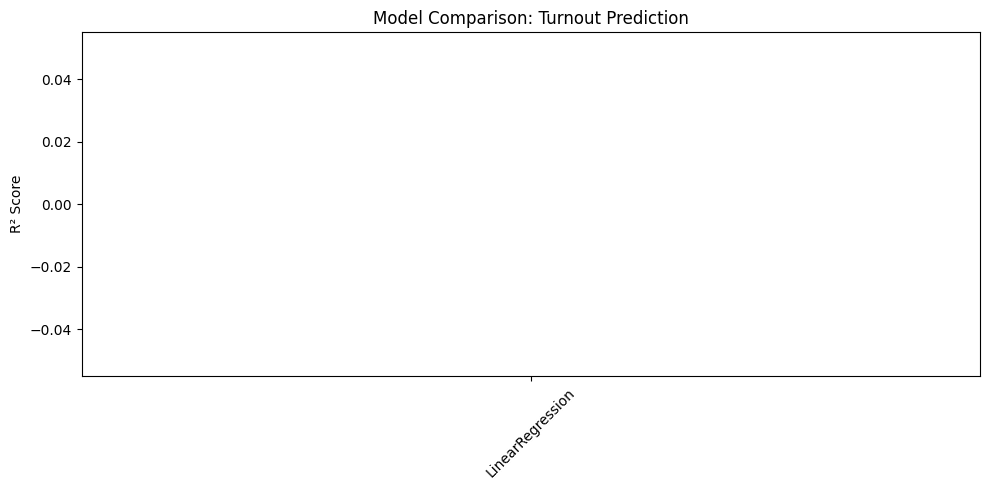

In [73]:
# =========================
# 🔹 SECTION 2: TURNOUT MODEL - ENSEMBLE COMPARISON
# =========================
if 'Election_Type' in turnout_df.columns:
    turnout_df = turnout_df[turnout_df['Election_Type'] == 'Presidential General']

turnout_features = [
    'Year', 'Turnout_Percent', 'Voted', 'Election_Type', 'Major_Race_Flag',
    'COVID_Impact_Flag', 'Weather_Severity',
    'Percent_Age_18_29', 'Percent_Age_30_44',
    'Percent_Age_45_64', 'Percent_Age_65plus',
    'Median_Income', 'Percent_College_Grad',
    'Past_Turnout_1', 'Past_Turnout_2'
]
turnout_df = turnout_df[turnout_features]

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(turnout_df[['Election_Type']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Election_Type']))
turnout_df = pd.concat([turnout_df.drop(columns='Election_Type'), encoded_df], axis=1)

turnout_df = turnout_df.dropna(subset=['Turnout_Percent'])
X_turnout = turnout_df.drop(columns=['Turnout_Percent', 'Year'])
y_turnout = turnout_df['Turnout_Percent']

imputer = SimpleImputer(strategy='mean')
X_turnout = pd.DataFrame(imputer.fit_transform(X_turnout), columns=X_turnout.columns)
scaler_turnout = StandardScaler()
X_turnout_scaled = scaler_turnout.fit_transform(X_turnout)

models = {
    'LinearRegression': LinearRegression(),
    'RidgeCV': RidgeCV(alphas=[0.1, 1.0, 10.0], cv=3),
    'LassoCV': LassoCV(cv=3),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(n_neighbors=3)
}

model_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_turnout_scaled, y_turnout, cv=3, scoring='r2')
    model_scores[name] = scores.mean()

# 🔍 Visualize model performance
plt.figure(figsize=(10, 5))
plt.bar(model_scores.keys(), model_scores.values(), color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("R² Score")
plt.title("Model Comparison: Turnout Prediction")
plt.tight_layout()
plt.show()

# Choose best model
best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]
best_model.fit(X_turnout_scaled, y_turnout)

x_2028 = pd.DataFrame([dict(zip(X_turnout.columns, [0]*len(X_turnout.columns)))])
x_2028.loc[0, 'Voted'] = 0
x_2028.loc[0, 'Major_Race_Flag'] = 1
x_2028.loc[0, 'COVID_Impact_Flag'] = 0
x_2028.loc[0, 'Weather_Severity'] = 0
x_2028.loc[0, 'Percent_Age_18_29'] = 14.5
x_2028.loc[0, 'Percent_Age_30_44'] = 21.0
x_2028.loc[0, 'Percent_Age_45_64'] = 37.5
x_2028.loc[0, 'Percent_Age_65plus'] = 27.0
x_2028.loc[0, 'Median_Income'] = 66000
x_2028.loc[0, 'Percent_College_Grad'] = 33.0
x_2028.loc[0, 'Past_Turnout_1'] = 66.3
x_2028.loc[0, 'Past_Turnout_2'] = 52.9

x_2028_scaled = scaler_turnout.transform(x_2028)
predicted_turnout_2028 = best_model.predict(x_2028_scaled)[0]

In [74]:
# =========================
# 🔹 SECTION 3: VOTE SHARE MODEL (RIDGE)
# =========================
vs_df = vote_share_df.drop(columns=['Dem_Votes', 'Rep_Votes', 'Total'])
vs_df = vs_df.dropna()
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(vs_df[['Election_Type']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Election_Type']))
vs_df = pd.concat([vs_df.drop(columns='Election_Type'), encoded_df], axis=1)

X_vote = vs_df.drop(columns=['Dem_Share', 'Rep_Share', 'Year'])
y_vote = vs_df['Dem_Share']
scaler_vote = StandardScaler()
X_vote_scaled = scaler_vote.fit_transform(X_vote)

ridge_vote = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=3)
ridge_vote.fit(X_vote_scaled, y_vote)

x_vote_2028 = pd.DataFrame([dict(zip(X_vote.columns, [0]*len(X_vote.columns)))])
x_vote_2028.loc[0, 'Turnout_Percent'] = predicted_turnout_2028
x_vote_2028.loc[0, 'Major_Race_Flag'] = 1
x_vote_2028.loc[0, 'COVID_Impact_Flag'] = 0
x_vote_2028.loc[0, 'Weather_Severity'] = 0
x_vote_2028.loc[0, 'Dem_Implied_Prob_2028'] = 0.424
x_vote_2028.loc[0, 'Rep_Implied_Prob_2028'] = 0.559
x_vote_2028.loc[0, 'Ind_Implied_Prob_2028'] = 0.0093

x_vote_2028_scaled = scaler_vote.transform(x_vote_2028)
predicted_dem_share = ridge_vote.predict(x_vote_2028_scaled)[0]
predicted_rep_share = 100 - predicted_dem_share

In [75]:
# =========================
# 🔹 SECTION 4: PROJECT FINAL VOTE COUNTS & WINNER
# =========================
reg_voters = 84000
predicted_votes = reg_voters * (predicted_turnout_2028 / 100)
predicted_dem_votes = round(predicted_votes * (predicted_dem_share / 100))
predicted_rep_votes = round(predicted_votes * (predicted_rep_share / 100))
winner = "Democrat" if predicted_dem_votes > predicted_rep_votes else "Republican"

# Mathematical Derivation Note:
# Let T be the predicted turnout percentage
# Let V be registered voters, D% the Dem share, R% the Rep share
# Then:  DemVotes = V * (T / 100) * (D / 100)
#         RepVotes = V * (T / 100) * (R / 100)

print("Final Prediction Summary")
print("-------------------------")
print(f"Best Turnout Model: {best_model_name}")
print(f"Predicted Turnout %: {predicted_turnout_2028:.2f}%")
print(f"Predicted Dem Share: {predicted_dem_share:.2f}%")
print(f"Predicted Rep Share: {predicted_rep_share:.2f}%")
print(f"Projected Democratic Votes: {predicted_dem_votes:,}")
print(f"Projected Republican Votes: {predicted_rep_votes:,}")
print(f"🏁 Predicted Winner: {winner}")

Final Prediction Summary
-------------------------
Best Turnout Model: LinearRegression
Predicted Turnout %: 54.73%
Predicted Dem Share: 54.29%
Predicted Rep Share: 45.71%
Projected Democratic Votes: 24,960
Projected Republican Votes: 21,016
🏁 Predicted Winner: Democrat


In [76]:
print("Shape of X_turnout:", X_turnout.shape)
print("Any NaNs in X_turnout?", X_turnout.isnull().any().any())
print("Any NaNs in y_turnout?", y_turnout.isnull().any())
print("Unique values in y_turnout:", y_turnout.unique())
print("y_turnout range:", y_turnout.min(), "to", y_turnout.max())


Shape of X_turnout: (4, 12)
Any NaNs in X_turnout? False
Any NaNs in y_turnout? False
Unique values in y_turnout: [68.60606061 68.86227545 68.08502925 68.3807558 ]
y_turnout range: 68.08502925 to 68.8622754491018
